### Dataset to use - change this value to analyze a different data set

In [1]:
dataset = 'twenty_sparse'

In [2]:
from analysis import check_folder
check_folder.check_folder(dataset)

[]

In [3]:
import pandas as pd

def order_tpr_fpr(fprs, tprs):
    df = pd.DataFrame(dict(fpr=fprs, tpr=tprs))
    df.sort_values('fpr', ascending=False)
    df.drop_duplicates(subset='fpr', keep='last', inplace=True)
    return df
    
    
a = order_tpr_fpr([.2, .1, .2], [.3, .2, .4])

### Load in parent probabilities and rates

In [4]:
from analysis import check_gies
import numpy as np
import itertools as itr

In [5]:
dag_folders = check_gies.get_dag_folders(dataset)
true_dags = check_gies.get_true_dags(dag_folders)
print('loaded DAGs')
parent_probs_by_dag = check_gies.get_parent_probs_by_dag(dag_folders, 9)
print('Computed parent probabilities')

loaded DAGs
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag0
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag7
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag9
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag8
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag6
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag1
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag34
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag33
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag32
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag35
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag44
/Users/chandlersquires/Documents/active_learning/new/data/twenty_sparse/dags/dag4

### Load the rates DataArray, a 7-dimensional tensor mapping each strategy (strategy name, n, b, k) and significance level to the value of a rate for all DAGs

In [6]:
strategy_names = ['entropy']
ks = [2]
bs = [1, 2]
ns = [12, 24, 48]
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [7]:
rates_da = check_gies.get_rates_data_array(
    parent_probs_by_dag,
    true_dags,
    target=9,
    strategy_names=strategy_names,
    ks=ks,
    bs=bs,
    ns=ns,
    alphas=np.linspace(0, 1, 11)
)
print(rates_da.dims)

('strategy', 'k', 'b', 'n', 'alpha', 'rate', 'dag')


### Plot curves for each strategy

In [8]:
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams["figure.figsize"] =(20,12)
sns.set(font_scale=1.5)

In [9]:

linestyles = ['solid', 'dashed', 'dotted']
colors = sns.color_palette()
sample_handles = [
    mlines.Line2D([0], [0], color='k', linestyle=linestyle, label=n) 
    for n, linestyle in zip(ns, linestyles)
]
strat_handles = [
    mpatches.Patch(facecolor=color, label=strat)
    for strat, color in zip(strategy_names, colors)
]

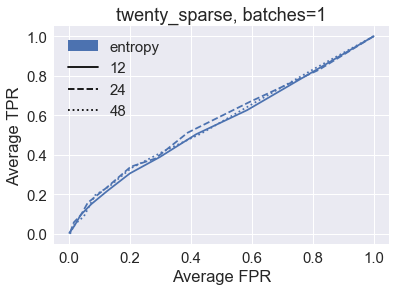

In [13]:
plt.clf()

rate_avgs_da = rates_da.mean(dim='dag')
b=1
for strategy, color in zip(strategy_names, colors):
    for n, linestyle in zip(ns, linestyles):
        strat_avg_tprs = rate_avgs_da.sel(strategy=strategy, b=b, k=2, n=n, rate='tpr').values
        strat_avg_fprs = rate_avgs_da.sel(strategy=strategy, b=b, k=2, n=n, rate='fpr').values
        tpr_fpr_df = order_tpr_fpr(strat_avg_fprs, strat_avg_tprs)
        plt.plot(tpr_fpr_df['fpr'], tpr_fpr_df['tpr'], linestyle=linestyle, color=color)

plt.legend(
    handles=strat_handles + sample_handles
)
plt.title(dataset + ', batches=%s' % b)
plt.xlabel('Average FPR')
plt.ylabel('Average TPR');

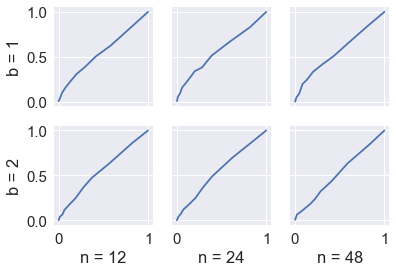

In [11]:
fig, ax = plt.subplots(len(bs), len(ns), sharey=True, sharex=True)
for (b_ix, b), (n_ix, n) in itr.product(list(enumerate(bs)), list(enumerate(ns))):
    for strategy, color in zip(strategy_names, colors):
        avg_rates = rate_avgs_da.sel(strategy=strategy, b=b, k=2, n=n)
        tpr_fpr_df = order_tpr_fpr(avg_rates.sel(rate='fpr').values, avg_rates.sel(rate='tpr').values)
        ax[b_ix, n_ix].plot(tpr_fpr_df['fpr'], tpr_fpr_df['tpr'], color=color)
        if b_ix == len(bs)-1:
            ax[b_ix, n_ix].set_xlabel('n = %s' % n)
        if n_ix == 0:
            ax[b_ix, n_ix].set_ylabel('b = %s' % b)


In [12]:
ns

[12, 24, 48]